In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

In [2]:
rutaArchivoDatos = (r"./recursos/1000gruposCluster.csv")
#el modelo y todos los archivos de salida se guardaran en el directorio ./modelos/
nombreModeloSalida = "forestRegressor.joblib"

In [3]:
data = pd.read_csv(rutaArchivoDatos)

data_filtered = data.drop(['CodigoInternoPuntoCarga', 'CodigoInternoPuntoDescarga', 'NumParadas', 'PorcentajePunto', 'Retraso', 'Cluster'], axis=1)
data_filtered

label_encoder_array = []
for col in data_filtered.columns:
    if data_filtered[col].dtype == 'object':
        label_encoder = LabelEncoder()
        data_filtered[col] = label_encoder.fit_transform(data[col])
        new_label_encoder = copy.deepcopy(label_encoder)
        label_encoder_array.append(new_label_encoder)

In [4]:
# # Cargar el dataset de iris
# data = load_iris()
# X = data.data
# print(X)
# y = data.target

# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = data_filtered.drop('Puntuacion', axis=1)  # Ajusta 'target_column' al nombre de tu columna de destino
y = data_filtered['Puntuacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print(X_train)

# Definir el modelo de Keras
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

# Clase para integrar Keras con scikit-learn para regresión
class KerasRegressorMSE(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.history_ = self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return -np.mean((y_pred - y) ** 2)  # Usar MSE negativo para que mayor sea mejor

# Integrar el modelo de Keras con scikit-learn
keras_reg = KerasRegressorMSE(build_model, epochs=50, batch_size=32, verbose=1)

# Entrenar el modelo
keras_reg.fit(X_train, y_train)

# Evaluar el modelo
mse = -keras_reg.score(X_test, y_test)
print(f'Mean Squared Error: {mse}')

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1776.9309 - mean_absolute_error: 32.4846 - mean_squared_error: 1776.9309
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 956us/step - loss: 288.0888 - mean_absolute_error: 13.4266 - mean_squared_error: 288.0888
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 940us/step - loss: 281.3242 - mean_absolute_error: 13.2123 - mean_squared_error: 281.3242
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 272.7994 - mean_absolute_error: 13.0181 - mean_squared_error: 272.7993
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 992us/step - loss: 270.0101 - mean_absolute_error: 12.9225 - mean_squared_error: 270.0101
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 995us/step - loss: 267.4103 - mean_absolute_error: 12.8380 - mean_squared_error: 267.4102
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 974us/step - loss: 266.8981 - mean_absolute_error: 12.8055 - mean_squared_error: 266.8981
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - l

In [5]:
# Clase para integrar Keras con scikit-learn para regresión
class KerasRegressorR2(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.history_ = self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_history(self):
        return self.history_

# Integrar el modelo de Keras con scikit-learn
keras_reg = KerasRegressorR2(build_model, epochs=100, batch_size=64, verbose=1)

# Entrenar el modelo
keras_reg.fit(X_train, y_train)

# Evaluar el modelo usando R2
r2 = keras_reg.score(X_test, y_test)
print(f'R2 Score: {r2:.2f}')

Epoch 1/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - loss: 647.0064 - mean_absolute_error: 19.6494 - mean_squared_error: 647.0065
Epoch 2/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 930us/step - loss: 283.2910 - mean_absolute_error: 13.4277 - mean_squared_error: 283.2910
Epoch 3/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - loss: 278.3367 - mean_absolute_error: 13.3176 - mean_squared_error: 278.3366
Epoch 4/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - loss: 275.7770 - mean_absolute_error: 13.2241 - mean_squared_error: 275.7770
Epoch 5/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - loss: 272.8313 - mean_absolute_error: 13.1814 - mean_squared_error: 272.8313
Epoch 6/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step - loss: 268.5880 - mean_absolute_error: 13.0565 - mean_squared_error: 268.5880
Epoch 7/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - loss: 266.9464 - mean_absolute_error: 13.0018 - mean_squared_error: 266.9464
Epoch 8/100
1919/1919 ━━━━━━━━━━━━━━━━━━━━ 2s 83

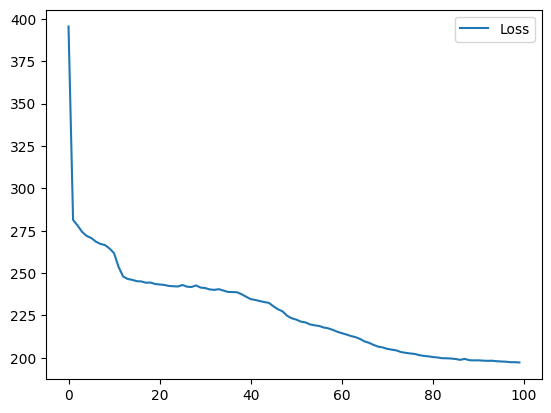

In [6]:
history = keras_reg.get_history()
loss_values =  history.history['loss']
# val_loss_values = history.history.get('val_loss', [])
# print(val_loss_values)
plt.plot(range(0, 100, 1), loss_values, label='Loss')
plt.legend()
plt.show()

In [10]:
conductores = data['IDConductor'].unique()
paradasCarga = pd.read_csv(r"./modelos/paradasCarga.csv")
paradasDescarga = pd.read_csv(r"./modelos/paradasDescarga.csv")
conductores.shape
import random

paradaCargaIndex = random.randint(0, len(paradasCarga)-1)
print(paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga)
paradaDescargaIndex = random.randint(0, len(paradasDescarga)-1)
lista_conductores_puntuacion = []
for conductor in conductores:
    km_vacio = random.randint(50, 400)
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        # 'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        # 'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1
    # print(to_pred)
    # print(to_pred['IDconductor'], "\n", to_pred['CodigoInternoParadaCarga'], "\n", to_pred['CodigoInternoParadaDescarga'])

    prediction = keras_reg.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction}
    lista_conductores_puntuacion.append(puntuacion_conductor)


print(lista_conductores_puntuacion)

conductores_ordenados = sorted(lista_conductores_puntuacion, key=lambda x: x["Prediccion"], reverse=True)
conductores_menosKM = sorted(lista_conductores_puntuacion, key=lambda x: x['KmVacio'], reverse=False)

for conductor in conductores_menosKM[:5]:
    print(conductor)

print("Mejores conductores:")
for conductor in conductores_ordenados[:5]:
    print(conductor)
    

100533515 28.456 -16.2654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


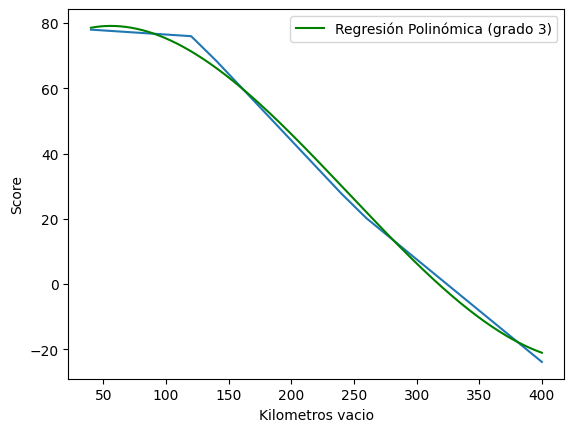

In [9]:
lista_conductorX_puntuaciones = []
conductor = "Y4446672G"
for km_vacio in range(40, 401, 20):
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        # 'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        # 'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1

    
    prediction = keras_reg.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction[0]}
    lista_conductorX_puntuaciones.append(puntuacion_conductor)
    

# for item in lista_conductorX_puntuaciones:
#     print(item)


# Extraer los valores de KmVacio y Prediccion
km_vacio = np.array([x["KmVacio"] for x in lista_conductorX_puntuaciones])
predicciones = np.array([x["Prediccion"] for x in lista_conductorX_puntuaciones])

# Ajustar una regresión polinómica (grado 2 en este caso)
grado = 3
coef = np.polyfit(km_vacio, predicciones, grado)
polinomio = np.poly1d(coef)

# Calcular los valores predichos usando el polinomio
y_pred2 = polinomio(km_vacio)

plt.plot(range(40, 401, 20), [x["Prediccion"] for x in lista_conductorX_puntuaciones])
# Graficar la curva de regresión polinómica
x_range = np.linspace(km_vacio.min(), km_vacio.max(), 500)
plt.plot(x_range, polinomio(x_range), color='green', label=f'Regresión Polinómica (grado {grado})')
plt.xlabel('Kilometros vacio')
plt.ylabel('Score')
plt.legend()
plt.show()